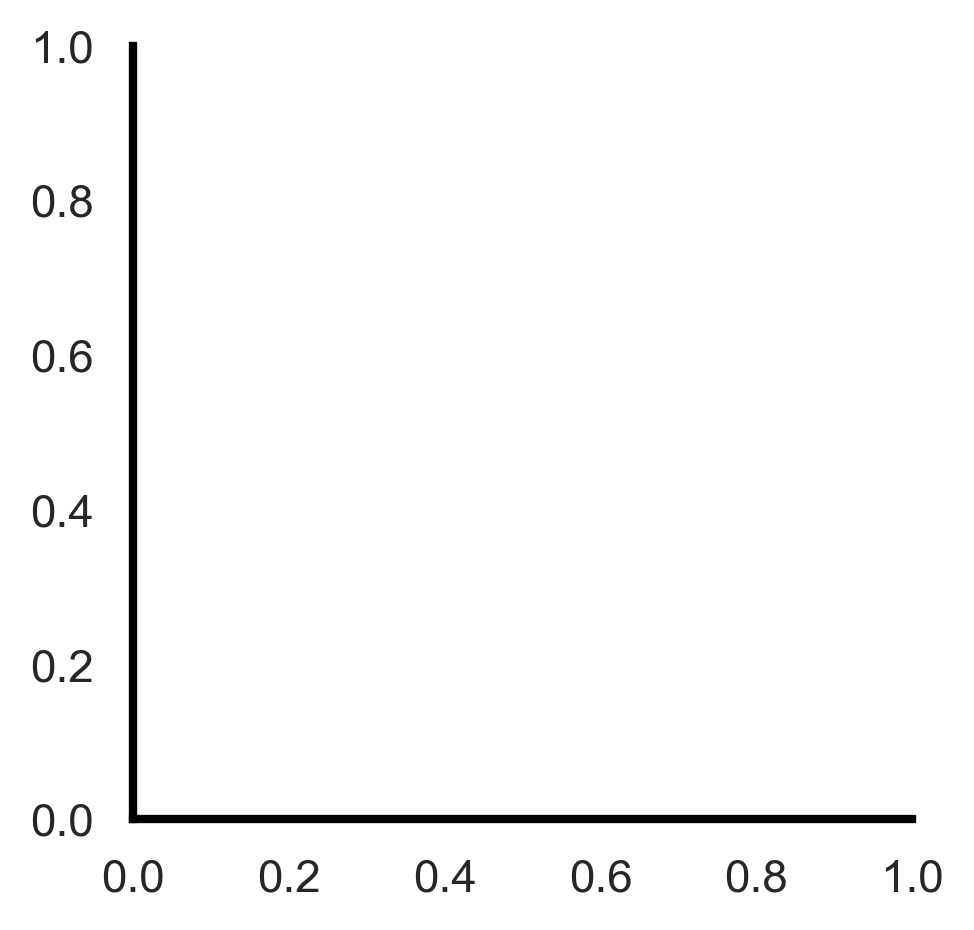

c:\Users\jaime\anaconda3\envs\ML_Playground_1\lib\site-packages\matplotlib\animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


cuda


In [38]:
from conway_lib import ConwayGame, Tokenizer, ConwayModel
conway_game = ConwayGame()
import os
import torch
from x_transformers import TransformerWrapper, Decoder
from x_transformers.autoregressive_wrapper import AutoregressiveWrapper
import numpy as np
import random
import typing
import matplotlib.pyplot as plt
os.environ['TORCH_USE_CUDA_DSA'] = '1'
# Function to clear CUDA cache
def empty_cuda_cache():
    torch.cuda.empty_cache()

# Ensure Torch is using Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def count_mismatches(ground_truth, pred):
        mismatches = sum(1 for gt, p in zip(ground_truth, pred) if gt != p)
        accuracy = 1 - mismatches / len(ground_truth)
        return mismatches, accuracy

def extract_sample(string_input, start_token='[', end_token=']'):
    i = string_input.find(start_token)
    j = string_input.find(end_token)
    return string_input[i+1:j]

def extract_task(string_input, end_task_token='>'):
    j = string_input.find(end_task_token)
    return string_input[:j+1]

# Function to load the model
def load_model(model_path, max_length, num_words):
    empty_cuda_cache()
    
    model = TransformerWrapper(
        num_tokens=num_words,
        max_seq_len=max_length,
        attn_layers=Decoder(
            dim=256,
            depth=12,
            heads=8,
            attn_dim_head=64,
            rotary_pos_emb=True,
            attn_flash=True
        )
    )
    model = AutoregressiveWrapper(model)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    print(f"Model loaded from {model_path}")
    
    return model

# Define Tokenizer class
class Tokenizer:
    def __init__(self, n_pad: int, device: torch.device, pad_byte: int = 0):
        self.n_pad = n_pad
        self.device = device
        self.pad_byte = pad_byte

    def tokenize_str(self, sentence: str, encoding="utf8", do_padding=True):
        base = list(bytes(sentence, encoding))
        if do_padding:
            if len(base) < self.n_pad:
                base.extend([self.pad_byte] * (self.n_pad - len(base)))
            assert len(base) == self.n_pad, f"n_pad is too small, use {len(base)} or greater."
        tensor = torch.Tensor(base)
        return tensor.long().to(self.device)

    def texts_to_sequences(self, texts: typing.List[str], encoding="utf8", do_padding=True):
        sentences = [self.tokenize_str(sentence, do_padding=do_padding).unsqueeze(0) for sentence in texts]
        return torch.cat(sentences, dim=0).to(self.device)

    def sequences_to_texts(self, texts: torch.Tensor, encoding="utf8"):
        out = []
        for seq in texts:
            chars = []
            i = 0
            while i < len(seq) and seq[i] != 0:
                chars.append(int(seq[i]))
                i += 1
            try:
                out.append(bytes(chars).decode(encoding))
            except:
                pass
        return out

# Define function to generate validation data
def generate_validation_data(conway_game, val_size, s, e):
    validation_data = conway_game.generate_validation_sets(A=val_size, N=30, I=2, s=s, e=e)
    X_data_val = ["@PredictNextState<" + state[0] + "> [" + state[1] + "]$" for state in validation_data]
    return X_data_val, np.linspace(s, e, val_size)

# Define function to test the model on validation data
def test_model(model, tokenizer, X_data_val):
    model.eval()
    results = []
    total_accuracy = 0
    num_samples = len(X_data_val)
    accuracies = []
    
    for counter, val in enumerate(X_data_val, 1):
        print(counter)
        ground_truth = extract_sample(val)
        task = extract_task(val)
        inp = torch.Tensor(tokenizer.texts_to_sequences(task, do_padding=False)).to(device)
        inp = inp.transpose(0, 1)
        inp = inp.long()
        
        with torch.no_grad():
            sample = model.generate(
                prompts=inp,
                seq_len=904,
                cache_kv=True
            )
        
        try:
            output_str = tokenizer.sequences_to_texts(sample[:1])
            pred = extract_sample(output_str[0])
            mismatches, accuracy = count_mismatches(ground_truth, pred)
            print(f"Accuracy for val sample {counter} is {accuracy}.")
            total_accuracy += accuracy
            accuracies.append(accuracy)
            results.append((val, output_str[0], accuracy))
        except Exception as e:
            print(f"Error decoding output: {e}")
            accuracies.append(0)
            results.append((val, "Error decoding output", 0))
    
    overall_accuracy = total_accuracy / num_samples
    return results, overall_accuracy, accuracies

In [2]:

# model_path = "C:\\Users\\jaime\\ML_Playground_1\\model_parameters\\07_05_2024_Conway_2_State_Jump_Rot_Pos_On_2024-07-06 19-01-21\\Conway_GPT_v7_epoch_30.pt"
# max_length = 1823  # Adjust this value as needed
# num_words = 256  # Adjust this value as needed

# # Load the model
# model = load_model(model_path, max_length, num_words)

# # Initialize tokenizer
# tokenizer = Tokenizer(max_length, device)

Model loaded from C:\Users\jaime\ML_Playground_1\model_parameters\07_05_2024_Conway_2_State_Jump_Rot_Pos_On_2024-07-06 19-01-21\Conway_GPT_v7_epoch_30.pt


In [39]:
data_path = "Conway_GPT_v8\\"

test_file = data_path + "conway_test_states_32by32_20240716_151502.csv"

In [40]:

import pandas as pd
df_test = pd.read_csv(test_file)


In [41]:
future_steps_list = [2, 3, 5, 10]
start_char = '@'
end_char = '$'
mask_char = ['_']
# Function to generate data
def generate_data(df, future_steps):
    X_data = []
    for i in range(len(df['State 1'])):
        future_state_col = f'State {future_steps}'
        if future_state_col in df.columns:
            str_ = f"{start_char}PredictNextState<{df['State 1'][i]}> [{df[future_state_col][i]}]{end_char}"
            X_data.append(str_)
    return X_data
X_data_test = {steps: generate_data(df_test, steps) for steps in future_steps_list}


In [42]:
print(X_data_test[2][4])

@PredictNextState<1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111

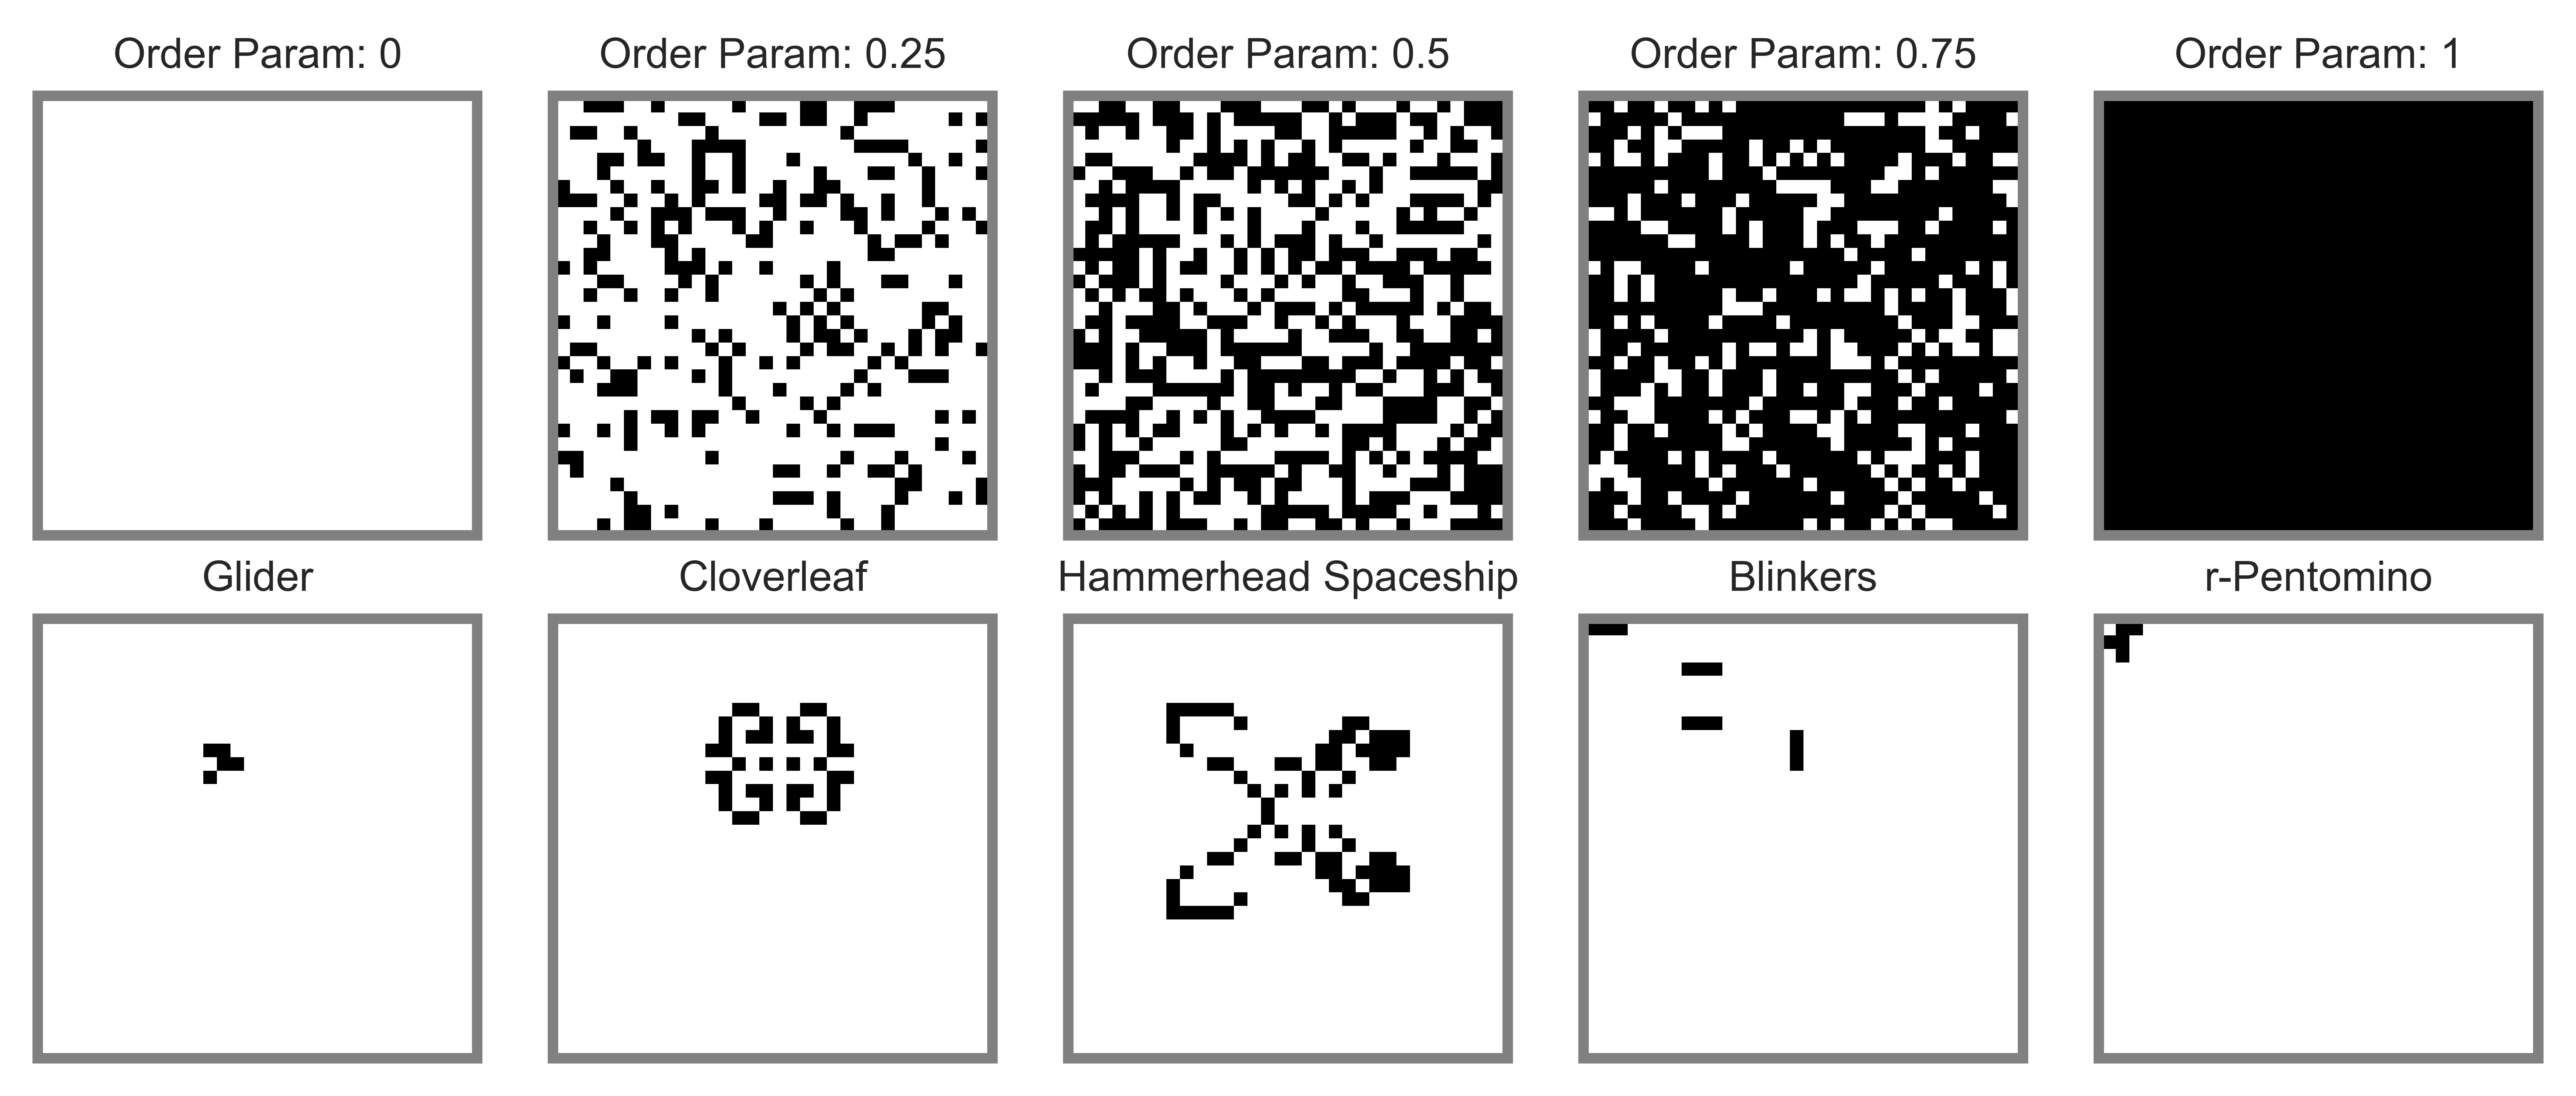

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import re

def parse_and_convert(data):
    """
    Parses the given data to extract state1 and state2, converts them into square images.
    
    Parameters:
    data (str): String data containing state1 and state2.
    
    Returns:
    tuple: Two 2D arrays representing the square images for state1 and state2.
    """
    state1_pattern = re.search(r'@PredictNextState<([^>]*)>', data)
    state2_pattern = re.search(r'\[([^]]*)\]\$', data)

    if not state1_pattern or not state2_pattern:
        raise ValueError("Input data does not match the expected format")

    state1 = state1_pattern.group(1)
    state2 = state2_pattern.group(1)

    def convert_to_square_image(state):
        length = len(state)
        size = int(np.sqrt(length))
        assert size * size == length, "State length is not a perfect square"
        image = np.array([int(pixel) for pixel in state]).reshape((size, size))
        return image

    state1_image = convert_to_square_image(state1)
    state2_image = convert_to_square_image(state2)

    return state1_image, state2_image

def display_images(data_list, names):
    """
    Converts and displays all initial condition images in data_list as square images in a 5x2 subplot figure,
    with assigned names to each sample.
    
    Parameters:
    data_list (list of str): List containing string data with state1 and state2.
    names (list of str): List containing names for each sample.
    """
    num_samples = len(data_list)
    if num_samples > 10:
        raise ValueError("The number of samples exceeds the 5x2 grid capacity.")

    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(7.01, 3), dpi=1000)
    axes = axes.flatten()  # Flatten to easily index into 1D array

    for i, (data, name) in enumerate(zip(data_list, names)):
        state1_image, _ = parse_and_convert(data)  # We only need state1_image
        
        axes[i].imshow(state1_image, cmap='gray_r', vmin=0, vmax=1)
        border_offset = 0.25  # Adjust this value as needed

        translation_x = -0.5  # Adjust this value for horizontal translation
        translation_y = -0.5  # Adjust this value for vertical translation

        axes[i].add_patch(patches.Rectangle((-border_offset + translation_x, -border_offset + translation_y), 
                                            state1_image.shape[1] + 2*border_offset, 
                                            state1_image.shape[0] + 2*border_offset, 
                                            linewidth=2, edgecolor='grey', facecolor='none', transform=axes[i].transData, clip_on=False))

        axes[i].set_title(name, fontsize=8)  # Use the provided names
        axes[i].axis('off')
        
    # Hide any unused subplots
    for j in range(i + 1, 10):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage with names
names = [
    "Order Param: 0",
    "Order Param: 0.25",
    "Order Param: 0.5",
    "Order Param: 0.75",
    "Order Param: 1",
    "Glider",
    "Cloverleaf",
    "Hammerhead Spaceship",
    "Blinkers",
    "r-Pentomino"
]

display_images(X_data_test[2], names)  # Ensure to provide 10 samples or fewer for a 5x2 grid


In [42]:
torch.cuda.empty_cache()

now on epoch 2
Model loaded from C:\Users\jaime\ML_Playground_1\model_parameters\07_22_2024_Conway_2_State_Jump_Rot_Pos_On_Masking_On_Broad_Entrpoy_Homog_2024-07-23 10-37-31\Conway_GPT_v7_epoch_2.pt
testing model
1
task: @PredictNextState<00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

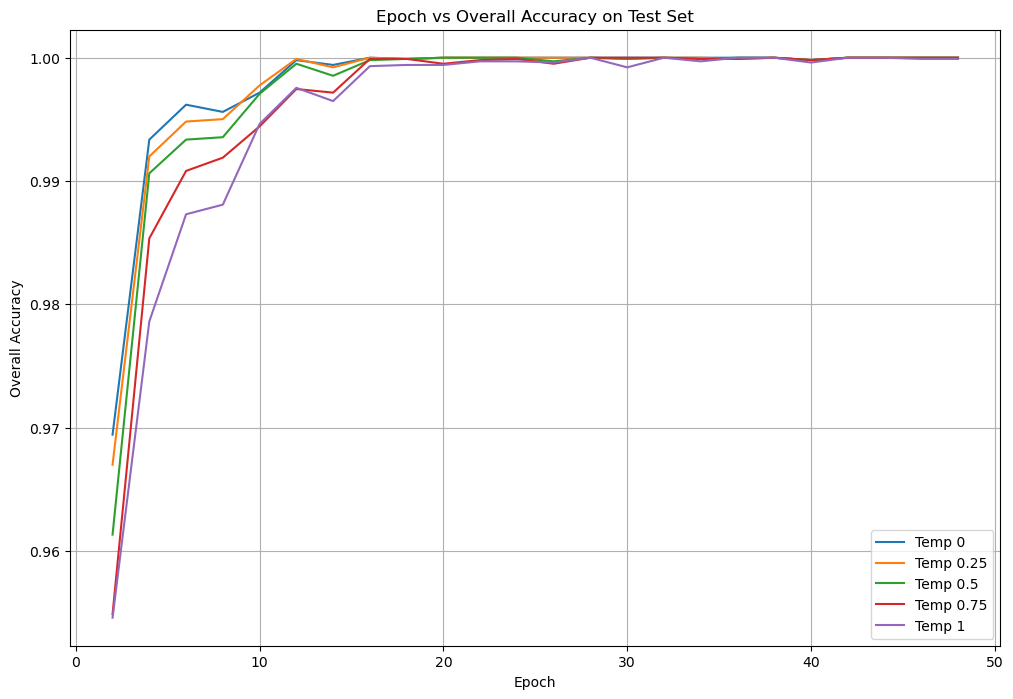

In [57]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import torch
from x_transformers import TransformerWrapper, Decoder
from x_transformers.autoregressive_wrapper import AutoregressiveWrapper
import typing

# Set the TORCH_USE_CUDA_DSA environment variable
os.environ['TORCH_USE_CUDA_DSA'] = '1'

# Define necessary classes and functions
class Tokenizer:
    def __init__(self, n_pad: int, device: torch.device, pad_byte: int = 0):
        self.n_pad = n_pad
        self.device = device
        self.pad_byte = pad_byte

    def tokenize_str(self, sentence: str, encoding="utf8", do_padding=True):
        base = list(bytes(sentence, encoding))
        if do_padding:
            if len(base) < self.n_pad:
                base.extend([self.pad_byte] * (self.n_pad - len(base)))
            assert len(base) == self.n_pad, f"n_pad is too small, use {len(base)} or greater."
        tensor = torch.Tensor(base)
        return tensor.long().to(self.device)

    def texts_to_sequences(self, texts: typing.List[str], encoding="utf8", do_padding=True):
        sentences = [self.tokenize_str(sentence, do_padding=do_padding).unsqueeze(0) for sentence in texts]
        return torch.cat(sentences, dim=0).to(self.device)

    def sequences_to_texts(self, texts: torch.Tensor, encoding="utf8"):
        out = []
        for seq in texts:
            chars = []
            i = 0
            while i < len(seq) and seq[i] != 0:
                chars.append(int(seq[i]))
                i += 1
            try:
                out.append(bytes(chars).decode(encoding))
            except:
                pass
        return out

def empty_cuda_cache():
    torch.cuda.empty_cache()

def load_model(model_path, max_length, num_words):
    empty_cuda_cache()
    
    model = TransformerWrapper(
        num_tokens=num_words,
        max_seq_len=max_length,
        attn_layers=Decoder(
            dim=256,
            depth=12,
            heads=8,
            attn_dim_head=64,
            rotary_pos_emb=True,
            attn_flash=True
        )
    )
    model = AutoregressiveWrapper(model)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    print(f"Model loaded from {model_path}")
    
    return model

def count_mismatches(ground_truth, pred):
    mismatches = sum(1 for gt, p in zip(ground_truth, pred) if gt != p)
    accuracy = 1 - mismatches / len(ground_truth)
    return mismatches, accuracy

def extract_sample(string_input, start_token='[', end_token=']'):
    i = string_input.find(start_token)
    j = string_input.find(end_token)
    return string_input[i+1:j]

def extract_task(string_input, end_task_token='>'):
    j = string_input.find(end_task_token)
    return string_input[:j+1]

def test_model(model, tokenizer, X_data_val, temp):
    torch.cuda.empty_cache()
    model.eval()
    total_accuracy = 0
    num_samples = len(X_data_val)
    accuracies = []
    imperfect_samples = []
    
    counter = 1
    for val in X_data_val:
        val = str(val)
        print(counter)
        counter += 1
        ground_truth = extract_sample(val)
        inp = extract_task(val, end_task_token='>')
        print(f"task: {inp}")
        
        inp = torch.Tensor(tokenizer.texts_to_sequences(inp, do_padding=False)).to(device)
        inp = inp.transpose(0, 1)
        inp = inp.long()
        print(f"generate_length: {generate_length}")
        print(f"inp.shape: {inp.shape}")
        
        with torch.no_grad():
            sample = model.generate(
                prompts=inp,
                seq_len=generate_length,
                temperature=temp,
                cache_kv=True
            )
        
        try:
            output_str = tokenizer.sequences_to_texts(sample[:1])
            pred = extract_sample(output_str[0])
            print(f"Prediction: {pred}")
            mismatches, accuracy = count_mismatches(ground_truth, pred)
            total_accuracy += accuracy
            accuracies.append(accuracy)
            if accuracy < 1.0:
                imperfect_samples.append((counter, accuracy))
        except Exception as e:
            print(f"Error decoding output: {e}")
            accuracies.append(0)
            imperfect_samples.append((counter, 0))
        
        # Clear GPU memory after each iteration
        del sample, output_str, pred, inp
        torch.cuda.empty_cache()
    
    overall_accuracy = total_accuracy / num_samples
    return overall_accuracy, accuracies, imperfect_samples

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming X_data_test[2] is already defined
X_data_test_new = X_data_test[2]

# Calculate max_length and generate_length dynamically
max_length = len(X_data_test_new[0])
generate_length = max_length - len("@PredictNextState<>") - (32 * 32)

# Initialize tokenizer
tokenizer_X = Tokenizer(max_length, device)

# Define epoch range and temperatures
epochs = list(range(2, 50, 2))
temperatures = [0, 0.25, 0.5, 0.75, 1]

# List to accumulate results
all_results = []

# Loop through each combination of epoch and temperature
for epoch in epochs:
    print(f'now on epoch {epoch}')
    model_path = f"C:\\Users\\jaime\\ML_Playground_1\\model_parameters\\07_22_2024_Conway_2_State_Jump_Rot_Pos_On_Masking_On_Broad_Entrpoy_Homog_2024-07-23 10-37-31\\Conway_GPT_v7_epoch_{epoch}.pt"
    model = load_model(model_path, max_length, num_words)
    
    for temp in temperatures:
        print('testing model')
        overall_accuracy, accuracies, imperfect_samples = test_model(model, tokenizer_X, X_data_test_new, temp)
        
        # Append results to the list
        all_results.append({
            "Epoch": epoch,
            "Temperature": temp,
            "Overall_Accuracy": overall_accuracy,
            "Imperfect_Samples": imperfect_samples
        })
        
        # # Clear CUDA cache to manage memory
        torch.cuda.empty_cache()
    del model
    torch.cuda.empty_cache()
# Convert results to DataFrame
results_df = pd.DataFrame(all_results)

# Save DataFrame to CSV
results_df.to_csv("model_accuracy_results.csv", index=False)

# Plot accuracy vs epoch for each temperature
plt.figure(figsize=(12, 8))
for temp in temperatures:
    temp_data = results_df[results_df["Temperature"] == temp]
    plt.plot(temp_data["Epoch"], temp_data["Overall_Accuracy"], label=f"Temp {temp}")

plt.xlabel("Epoch")
plt.ylabel("Overall Accuracy")
plt.title("Epoch vs Overall Accuracy on Test Set")
plt.legend()
plt.grid(True)
plt.show()


In [44]:
import random
random.random()

0.7361257380764005

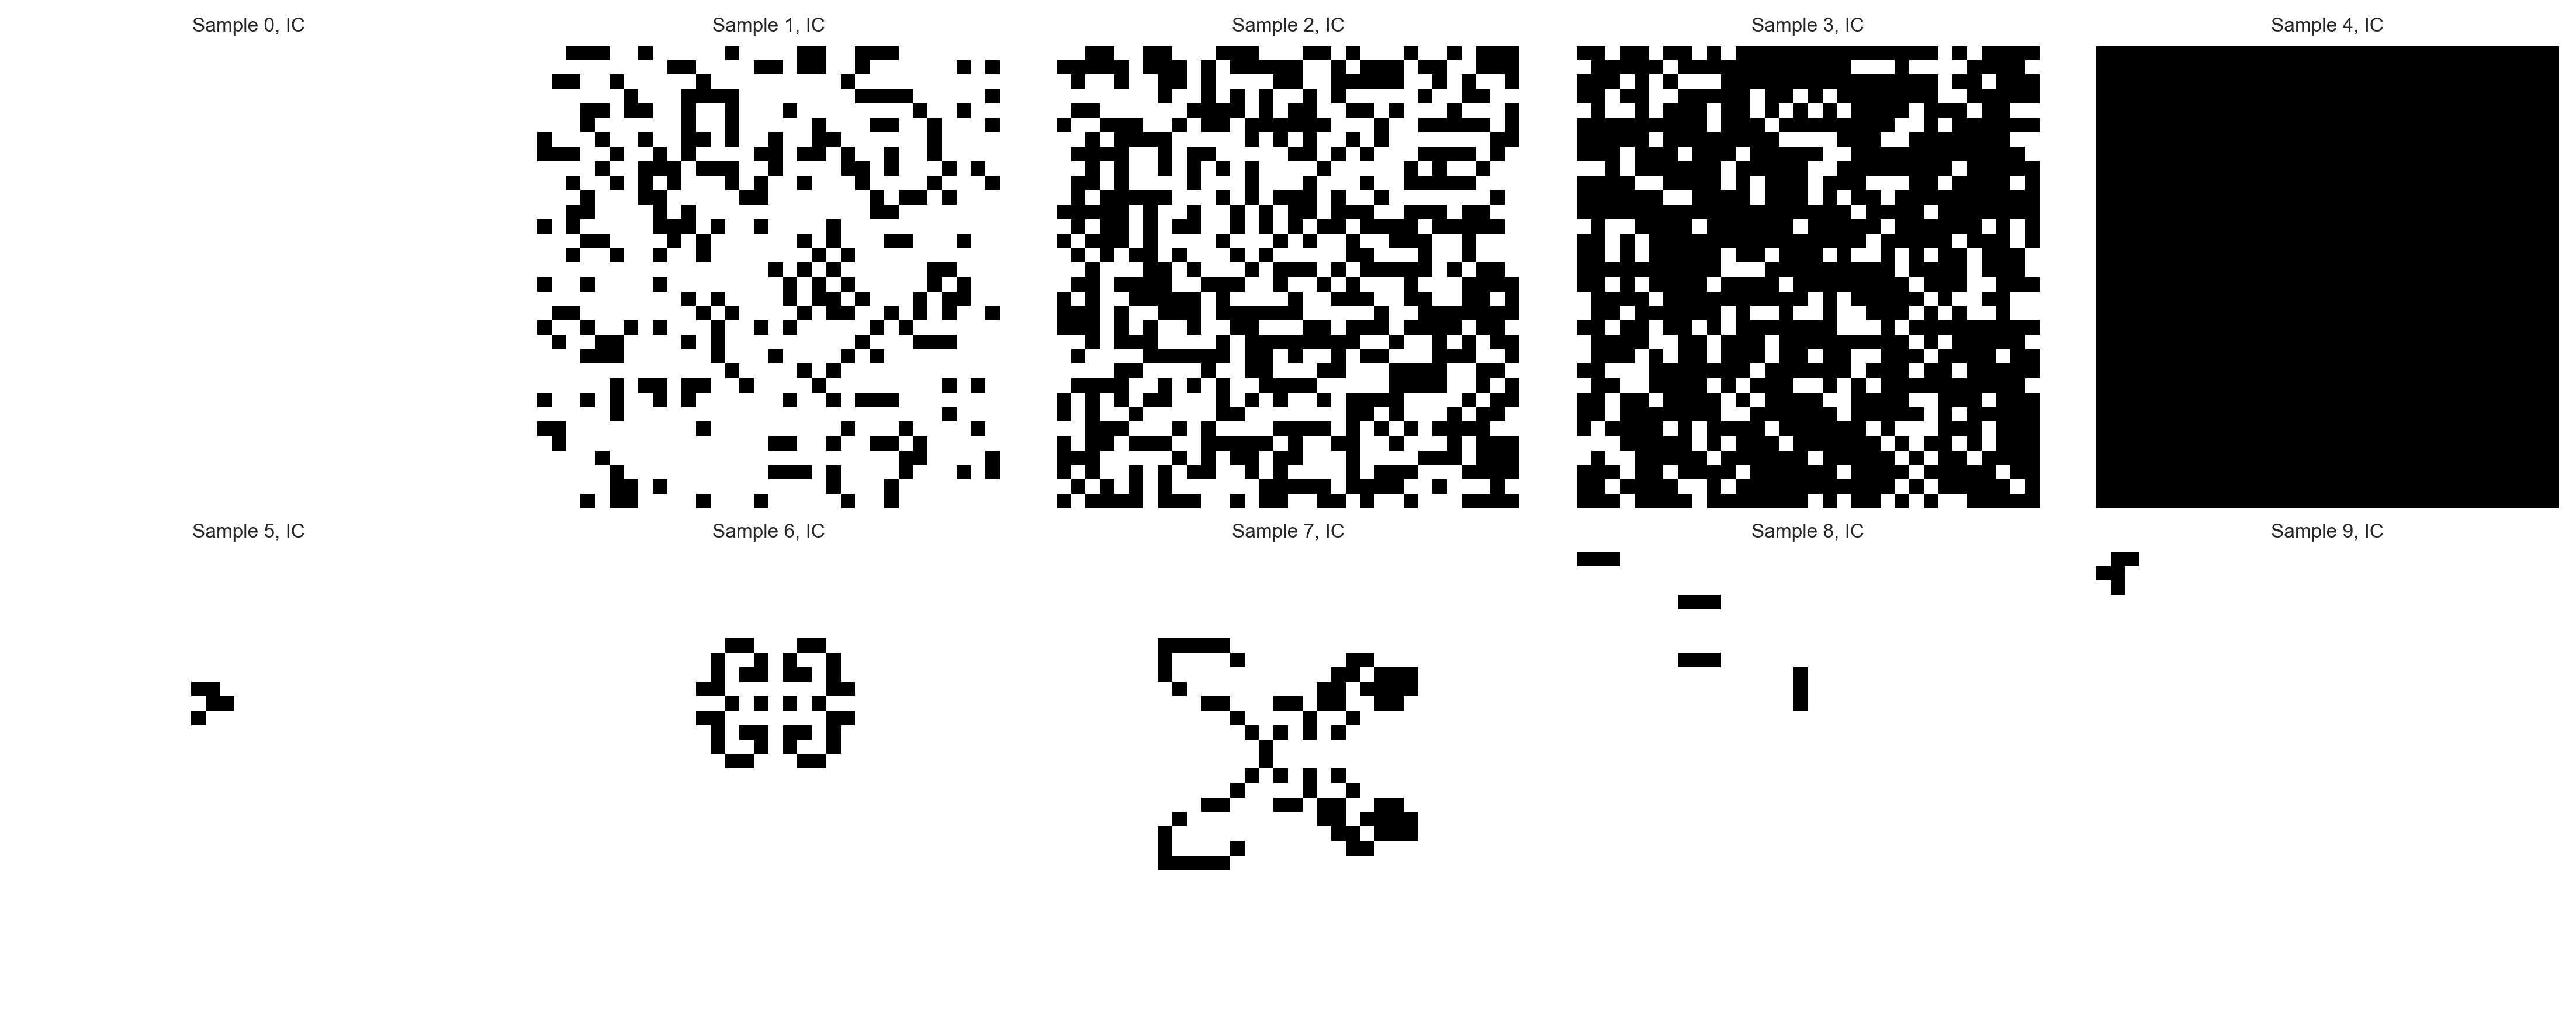

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import re

def parse_and_convert(data):
    """
    Parses the given data to extract state1 and state2, converts them into square images.
    
    Parameters:
    data (str): String data containing state1 and state2.
    
    Returns:
    tuple: Two 2D arrays representing the square images for state1 and state2.
    """
    state1_pattern = re.search(r'@PredictNextState<([^>]*)>', data)
    state2_pattern = re.search(r'\[([^]]*)\]\$', data)

    if not state1_pattern or not state2_pattern:
        raise ValueError("Input data does not match the expected format")

    state1 = state1_pattern.group(1)
    state2 = state2_pattern.group(1)

    def convert_to_square_image(state):
        length = len(state)
        size = int(np.sqrt(length))
        assert size * size == length, "State length is not a perfect square"
        image = np.array([int(pixel) for pixel in state]).reshape((size, size))
        return image

    state1_image = convert_to_square_image(state1)
    state2_image = convert_to_square_image(state2)

    return state1_image, state2_image

def display_images(data_list):
    """
    Converts and displays all initial condition images in data_list as square images in a 5x2 subplot figure.
    
    Parameters:
    data_list (list of str): List containing string data with state1 and state2.
    """
    num_samples = len(data_list)
    if num_samples > 10:
        raise ValueError("The number of samples exceeds the 5x2 grid capacity.")

    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6), dpi=300)
    axes = axes.flatten()  # Flatten to easily index into 1D array

    for i, data in enumerate(data_list):
        state1_image, _ = parse_and_convert(data)  # We only need state1_image
        
        axes[i].imshow(state1_image, cmap='gray_r', vmin=0, vmax=1)
        axes[i].set_title(f"Sample {i}, IC", fontsize=8)
        axes[i].axis('off')
        
    # Hide any unused subplots
    for j in range(i + 1, 10):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

display_images(X_data_test[2])  # Ensure to provide 10 samples or fewer for a 5x2 grid


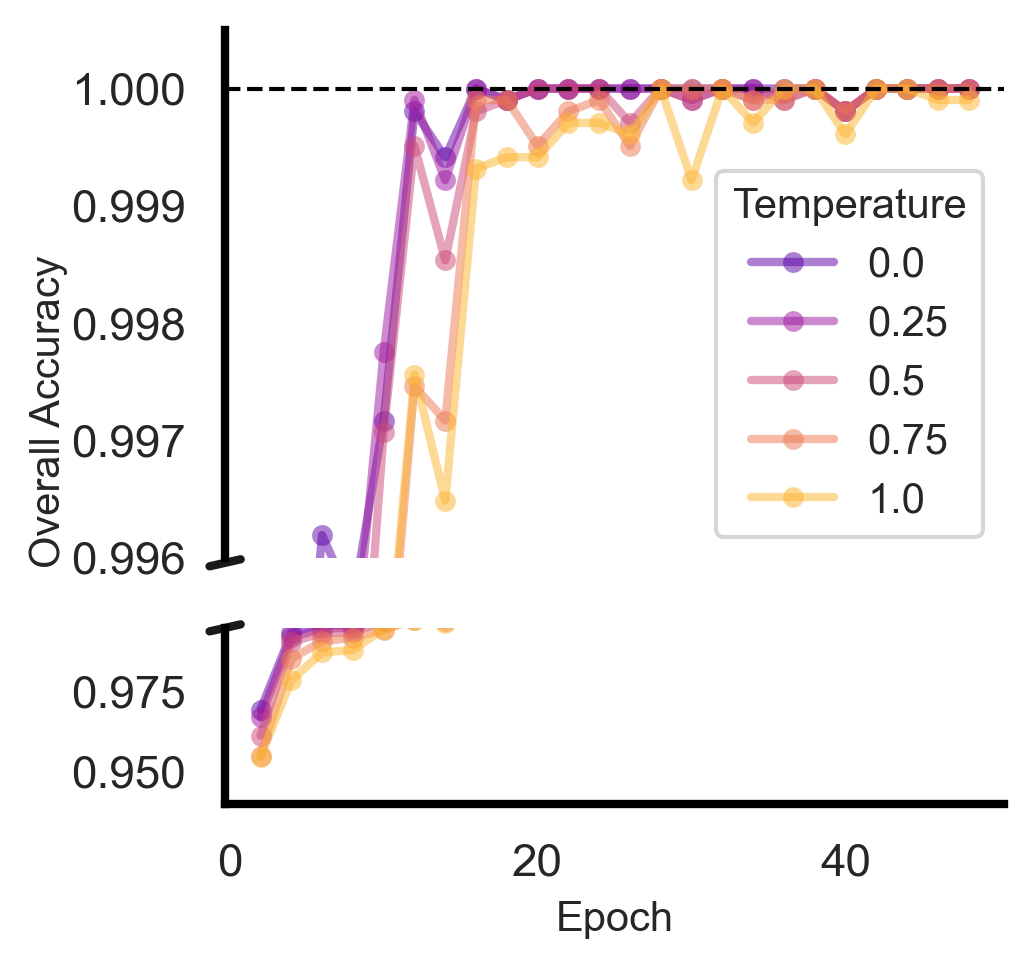

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np

# Load results from CSV
results_df = pd.read_csv("model_accuracy_results.csv")

# Number of unique temperatures (categories) to generate corresponding colors
unique_temperatures = results_df["Temperature"].nunique()

# Generate a discrete color palette from 'plasma'
plasma_palette = sns.color_palette("plasma", unique_temperatures)

# Apply the style
sns.set(style="whitegrid", rc={
    'figure.figsize': (3.35, 3.35),
    'figure.dpi': 300,
    'lines.linewidth': 2.0,
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.edgecolor': 'black',
    'axes.linewidth': 2.0,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.major.width': 2,
    'ytick.major.width': 2,
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'legend.fontsize': 10,
    'legend.title_fontsize': 10,
    'axes.grid': False
})

# Create the figure and two subplots
fig, (ax_inset, ax) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Plot the zoomed-in region on the inset axis (at the top)
sns.lineplot(data=results_df, x="Epoch", y="Overall_Accuracy", hue="Temperature", palette=plasma_palette, marker="o", alpha=0.5, markersize=5, ax=ax_inset, markeredgecolor='none')

# Set the y-limit for the inset to focus on the range 0.996 to 1.0
ax_inset.set_ylim(0.996, 1.0005)

# Hide the spines and ticks of the inset plot to give a clean "zoomed" effect
ax_inset.spines['top'].set_visible(False)
ax_inset.spines['right'].set_visible(False)
ax_inset.spines['bottom'].set_visible(False)
ax_inset.spines['left'].set_visible(True)
ax_inset.tick_params(bottom=False, labelbottom=False)  # Hide x-axis ticks

# Plot the full range on the main axis (at the bottom)
sns.lineplot(data=results_df, x="Epoch", y="Overall_Accuracy", hue="Temperature", palette=plasma_palette, marker="o", alpha=0.5, markersize=5, ax=ax, markeredgecolor='none')

# Set the y-limit for the main axis to exclude the zoomed-in region
ax.set_ylim(0.94, 0.995)

# Add a break mark on the y-axis to indicate the discontinuity
d = .02  # how big to make the diagonal lines in axes coordinates
mult = .33333
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal

kwargs.update(transform=ax_inset.transAxes)  # switch to the inset axes
ax_inset.plot((-d, +d), (-.01 - mult*d, -.01 + mult*d), **kwargs)  # top-left diagonal

# Add the black dotted line at y = 1 on the inset axis
ax_inset.axhline(y=1, color='black', linestyle='--', linewidth=1, zorder=10)

# Add labels and title
ax.set_xlabel("Epoch")
ax_inset.set_ylabel("")
ax.set_ylabel("")

# Customize the legend by removing it from the inset plot and keeping it in the main plot
ax.legend_.remove()
ax_inset.legend(title="Temperature", loc="lower right")
# Add a centered y-axis label for the entire figure, slightly moved to the left
fig.text(-0.05, 0.5, 'Overall Accuracy', va='center', ha='center', rotation='vertical', fontsize=10)

# Display the plot
plt.show()


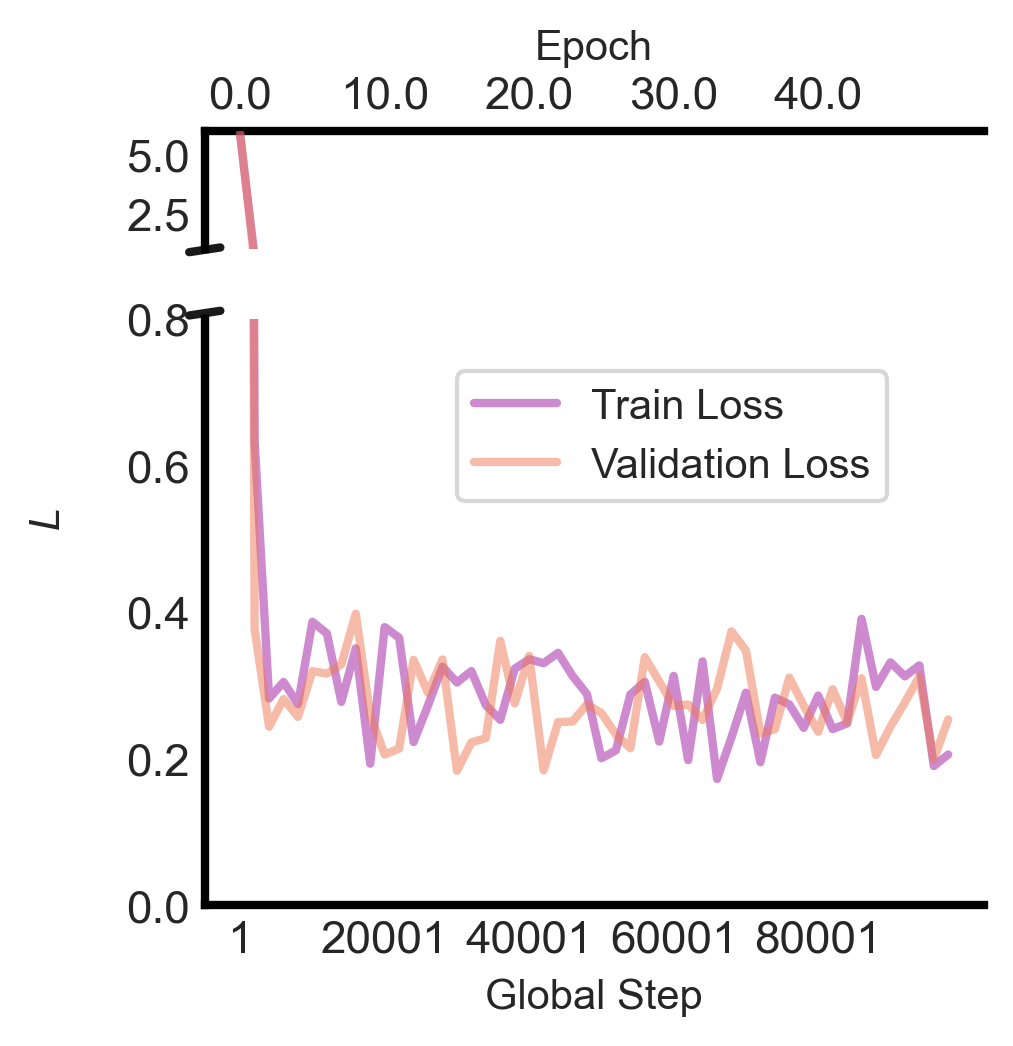

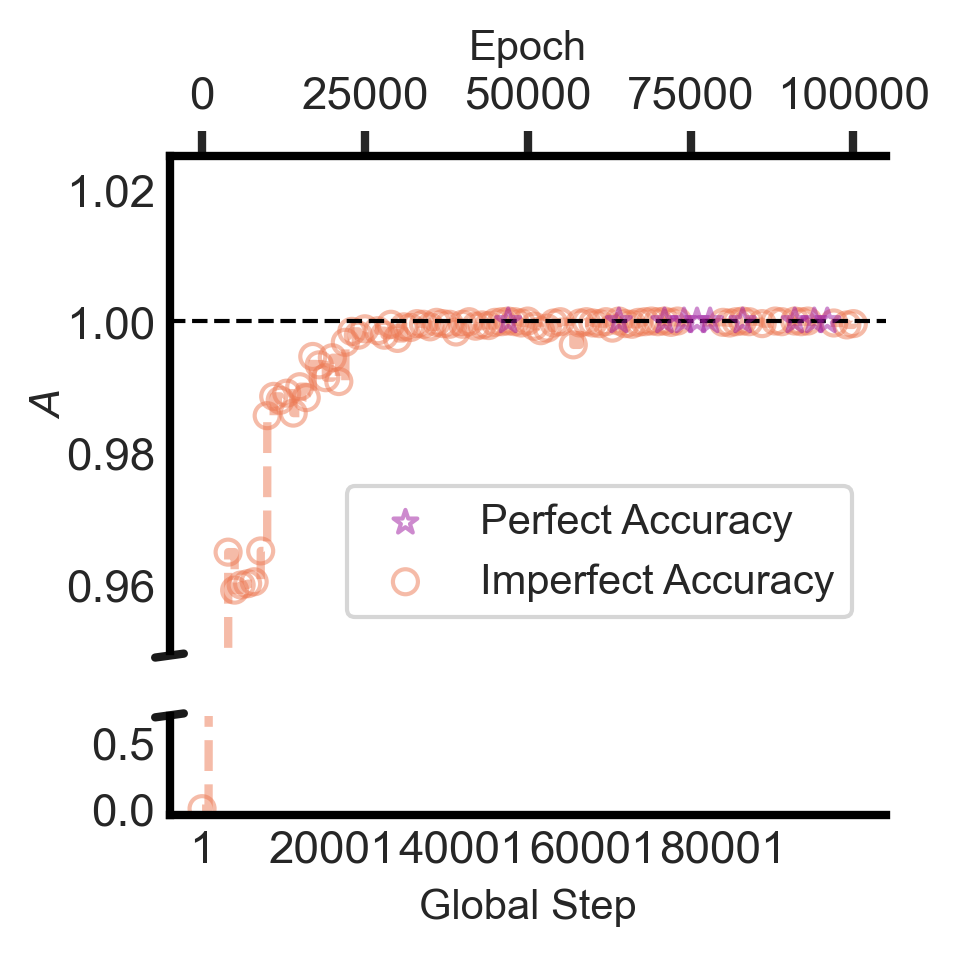

In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Hardcoded file directory (change this to your actual file path)
file_path = "C:\\Users\\jaime\\ML_Playground_1\\model_parameters\\07_22_2024_Conway_2_State_Jump_Rot_Pos_On_Masking_On_Broad_Entrpoy_Homog_2024-07-23 10-37-31\\loss_data.csv"

num_ticks = 5

# Read the CSV file
df = pd.read_csv(file_path)

# Adjust epochs and batches
df['epoch'] = df['epoch'] + 1
df['batch_overall'] = df['batch_overall'] + 1

# Apply the style similar to the second script
sns.set(style="whitegrid", rc={
    'figure.figsize': (3.35, 3.35),
    'figure.dpi': 300,
    'lines.linewidth': 2.0,
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.edgecolor': 'black',
    'axes.linewidth': 2.0,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.major.width': 2,
    'ytick.major.width': 2,
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'legend.fontsize': 10,
    'legend.title_fontsize': 10,
    'legend.loc': 'best',
    'axes.grid': False
})

# Define the Plasma palette
plasma_palette = sns.color_palette("plasma", 2)  # Adjust the number of colors as needed

# Set up the figure and axes for subplots with different height ratios
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(3.35, 3.35),
                               gridspec_kw={'height_ratios': [1, 5]})

# # Plot the data on both axes using the plasma palette
# sns.lineplot(x='batch_overall', y='train_loss', data=df, ax=ax1, label='Train Loss', color=plasma_palette[0], linewidth=2)
# sns.lineplot(x='batch_overall', y='val_loss', data=df, ax=ax1, label='Validation Loss', color=plasma_palette[1], linewidth=1)
# sns.lineplot(x='batch_overall', y='train_loss', data=df, ax=ax2, label='Train Loss', color=plasma_palette[0], linewidth=2)
# sns.lineplot(x='batch_overall', y='val_loss', data=df, ax=ax2, label='Validation Loss', color=plasma_palette[1], linewidth=1)

# Create a subset of the DataFrame for every 4th data point
df_subset = df.iloc[::2000]

# Plot the data on both axes using the plasma palette and the subset
sns.lineplot(x='batch_overall', y='train_loss', data=df_subset, ax=ax1, label='Train Loss', color=plasma_palette[0], linewidth=2, alpha=0.5)
sns.lineplot(x='batch_overall', y='val_loss', data=df_subset, ax=ax1, label='Validation Loss', color=plasma_palette[1], linewidth=2, alpha=0.5)
sns.lineplot(x='batch_overall', y='train_loss', data=df_subset, ax=ax2, label='Train Loss', color=plasma_palette[0], linewidth=2, alpha=0.5)
sns.lineplot(x='batch_overall', y='val_loss', data=df_subset, ax=ax2, label='Validation Loss', color=plasma_palette[1], linewidth=2, alpha=0.5)


# Zoom-in / limit the view to different portions of the data
ax1.set_ylim(1, 6)  # outliers only
ax2.set_ylim(0.0, 0.80)  # most of the data

# Hide the spines and ticks between ax1 and ax2
ax1.spines['bottom'].set_visible(False)  # Explicitly hide the bottom spine
ax1.tick_params(bottom=False)  # Hide the bottom ticks
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Diagonal lines indicating zoomed-in section
d = .02  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-.01-d, -.01+d), **kwargs)  # top-left diagonal
# ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1.01 - d/5, 1.01 + d/5), **kwargs)  # bottom-left diagonal
# ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# Set epoch labels on the top x-axis of ax1
ax1_secondary = ax1.secondary_xaxis('top')
ax1_secondary.set_xlabel('Epoch')

# Compute new tick labels (1/500th of the batch_overall)
batch_ticks = df['batch_overall'][::max(1, len(df) // num_ticks)]
scaled_ticks = batch_ticks / 2000  # Scale the tick values
ax1_secondary.set_xticks(batch_ticks)  # Use same tick positions
ax1_secondary.set_xticklabels(scaled_ticks.round(2))  # Set scaled tick labels and round them for better readability

# Set x-axis label and ticks for batches on the bottom plot
ax2.set_xlabel('Global Step')
batch_ticks = df['batch_overall'][::max(1, len(df) // num_ticks)]
ax2.set_xticks(batch_ticks)

# Create the second subplot: accuracy vs batch and epoch
fig2, (ax3, ax4) = plt.subplots(2, 1, sharex=True, figsize=(3.35, 3.35),
                               gridspec_kw={'height_ratios': [5, 1]})

# Separate the data for accuracy plots
accuracy_changes = df[df['accuracy'].diff() != 0]
accuracy_1 = df[df['accuracy'] == 1.0].iloc[::2000]  # Select every 250th row
accuracy_not_1 = df[df['accuracy'] != 1.0]

# Plot points with accuracy exactly 1.0 in green (outlined circles)
sns.scatterplot(x='batch_overall', y='accuracy', data=accuracy_1, ax=ax3, facecolors='none', edgecolor=plasma_palette[0], marker='*', label='Perfect Accuracy',zorder=5, linewidths=1, alpha=0.5)
sns.scatterplot(x='batch_overall', y='accuracy', data=accuracy_1, ax=ax4, facecolors='none', edgecolor=plasma_palette[0], marker='*', label='Perfect Accuracy',zorder=5, linewidths=1, alpha=0.5)

# Plot the rest of the accuracy points in blue (outlined circles)
sns.scatterplot(x='batch_overall', y='accuracy', data=accuracy_changes, ax=ax3, facecolors='none', edgecolor=plasma_palette[1], marker='o', label='Imperfect Accuracy',zorder=2, linewidths=1, alpha=0.5)
sns.scatterplot(x='batch_overall', y='accuracy', data=accuracy_changes, ax=ax4, facecolors='none', edgecolor=plasma_palette[1], marker='o', label='Imperfect Accuracy',zorder=2, linewidths=1, alpha=0.5)
sns.lineplot(x='batch_overall', y='accuracy', data=accuracy_not_1, ax=ax3, color=plasma_palette[1], linestyle='--', alpha=0.5)
sns.lineplot(x='batch_overall', y='accuracy', data=accuracy_not_1, ax=ax4, color=plasma_palette[1], linestyle='--', alpha=0.5)

# Add horizontal lines at y = 1
ax3.axhline(1, color='black', linestyle='--', linewidth=1)  
ax4.axhline(1, color='black', linestyle='--', linewidth=1)

# Zoom-in / limit the view to different portions of the data
ax3.set_ylim(0.95, 1.025)  # outliers only
ax4.set_ylim(-0.05, 0.7)  # most of the data

# Hide the spines and ticks between ax3 and ax4
ax3.spines['bottom'].set_visible(False)  # Explicitly hide the bottom spine
ax3.tick_params(bottom=False)  # Hide the bottom ticks
ax4.spines['top'].set_visible(False)
ax3.xaxis.tick_top()
ax3.tick_params(labeltop=False)  # don't put tick labels at the top
ax4.xaxis.tick_bottom()

# Diagonal lines indicating zoomed-in section
kwargs = dict(transform=ax3.transAxes, color='k', clip_on=False)
ax3.plot((-d, +d), (-.01-d/5, -.01+d/5), **kwargs)  # top-left diagonal
# ax3.plot((1 - d, 1 + d), (-d/5, +d/5), **kwargs)  # top-right diagonal

kwargs.update(transform=ax4.transAxes)  # switch to the bottom axes
ax4.plot((-d, +d), (1.01 - d, 1.01 + d), **kwargs)  # bottom-left diagonal
# ax4.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax4.set_xlabel('Global Step')

# Set epoch labels on the top x-axis of ax3
ax3_secondary = ax3.secondary_xaxis('top')
ax3_secondary.set_xlabel('Epoch')
# ax3_secondary.set_xticks(tick_positions)
# epoch_ticks = 2000
# ax3_secondary.set_xticklabels(epoch_ticks[::max(1, len(epoch_ticks) // num_ticks)])

# Match the tick marks on the bottom x-axis with fig1
ax4.set_xticks(batch_ticks)

# Ensure y-axis uses decimals
ax4.get_yaxis().get_major_formatter().set_scientific(False)
ax1.legend().set_visible(False)  # Remove the legend from ax2
ax4.legend().set_visible(False)  # Remove the legend from ax2
ax2.legend(loc='center', bbox_to_anchor=(.6, .8))
ax3.legend(loc='center', bbox_to_anchor=(.6, .2))

# ax2.legend(loc='center')



ax1.tick_params(axis='both', length=0)  # Hides tick marks for both x and y
ax2.tick_params(axis='both', length=0)  # Hides tick marks for both x and y
ax3.tick_params(axis='both', length=0)  # Hides tick marks for both x and y
ax4.tick_params(axis='both', length=0)  # Hides tick marks for both x and y
ax1_secondary.tick_params(axis='both', length=0)  # Hides tick marks for both x and y

# Assuming ax is your axis object
ax1.set_ylabel('')  # This hides the y-axis title
# Assuming ax is your axis object
ax2.set_ylabel('$L$', rotation=90, va='center')
ax4.set_ylabel('')  # This hides the y-axis title
ax3.set_ylabel('$A$', rotation = 90, va='center')  # This hides the y-axis title
ax2.yaxis.set_label_coords(-0.2, 0.66)

# Show the plots
plt.tight_layout()
plt.show()
